Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
--- Train with AdamW ---
Epoch 1/150, Train Acc: 8.04%, Val Acc: 14.46%
Epoch 1/150, Train Loss: 4.0405, Val Loss: 3.6396
Epoch 2/150, Train Acc: 15.68%, Val Acc: 20.26%
Epoch 2/150, Train Loss: 3.5532, Val Loss: 3.3092
Epoch 3/150, Train Acc: 20.54%, Val Acc: 25.06%
Epoch 3/150, Train Loss: 3.2647, Val Loss: 3.0507
Epoch 4/150, Train Acc: 23.97%, Val Acc: 27.35%
Epoch 4/150, Train Loss: 3.0844, Val Loss: 2.9416
Epoch 5/150, Train Acc: 26.43%, Val Acc: 28.68%
Epoch 5/150, Train Loss: 2.9461, Val Loss: 2.8748
Epoch 6/150, Train Acc: 28.79%, Val Acc: 32.09%
Epoch 6/150, Train Loss: 2.8198, Val Loss: 2.7006
Epoch 7/150, Train Acc: 31.31%, Val Acc: 33.72%
Epoch 7/150, Train Loss: 2.7115, Val Loss: 2.6147
Epoch 8/150, Train Acc: 32.67%, Val Acc: 34.48%
Epoch 8/150, Train Loss: 2.6309, Val Loss: 2.5832
Epoch 9/150, Train Acc: 34.48%, Val Acc: 34.97%
Epoch 9/150, Train Loss: 2.548

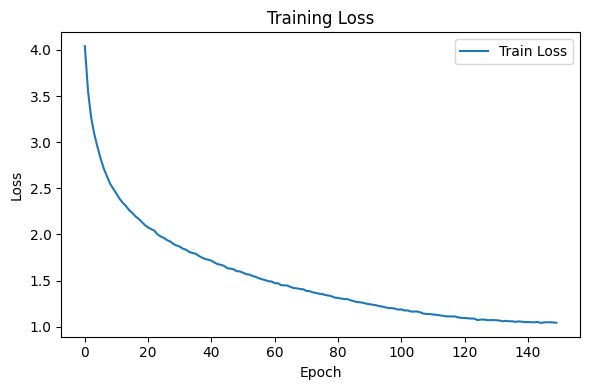

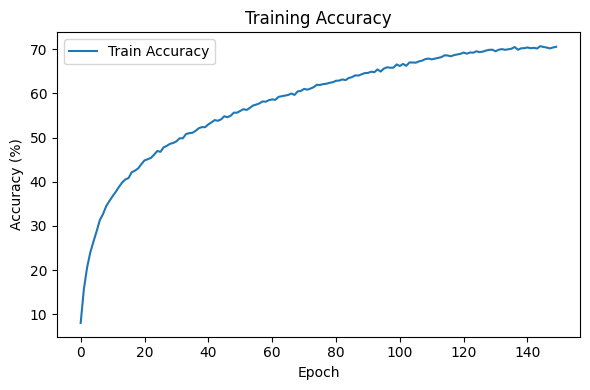

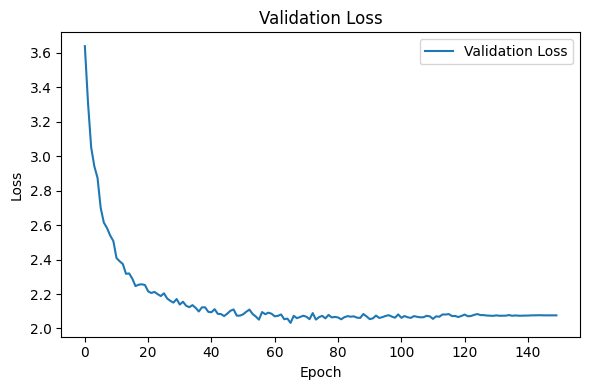

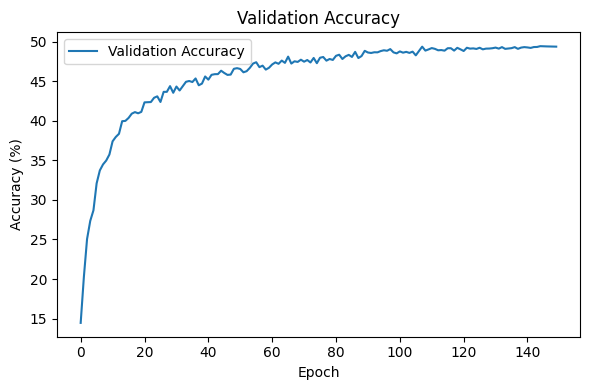

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from google.colab import files

# Training settings
# betas, epochs and batch sized are fixed values
epochs = 150
batch_size = 64
# weight decay and learning rate are adjustable
weight_decay = 1e-1
lr= 3e-4

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std


# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(), # Convert into tensor
    transforms.Normalize(mean, std)  # Normalization
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=val_transform)
indices = torch.randperm(len(trainset))
val_size = int(0.2*len(trainset))
trainset = torch.utils.data.Subset(trainset, indices[:-val_size])
valset = torch.utils.data.Subset(valset, indices[-val_size:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
net_adamw = LeNet5().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer and scheduler
adamw_optimizer = optim.AdamW(net_adamw.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler_adamw = optim.lr_scheduler.CosineAnnealingLR(adamw_optimizer, T_max=150)
'''
# Load a checkpoint, if exists
resume_training = True  # Put False if you want to start from scratch
start_epoch = 0  # default starting epoch

if resume_training and os.path.exists('checkpoint_epoch_30.pth'):
    checkpoint = torch.load('checkpoint_epoch_30.pth', map_location=device)
    net_adamw.load_state_dict(checkpoint['model_state_dict'])
    adamw_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint caricato: riprendo da epoca {start_epoch}")
else:
    print("Nessun checkpoint trovato, inizializzo da zero.")
'''

# Training function
def train_model(optimizer, scheduler, model, criterion, trainloader, valloader, device, epochs, save_checkpoint_interval=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, total_val, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        val_loss /= len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100. * correct_val / total_val
        val_accuracies.append(val_accuracy)

        scheduler.step()

        # Checkpointing
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }
            checkpoint_path = os.path.join('./', checkpoint_filename)
            torch.save(checkpoint, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch + 1}: {checkpoint_path}')

            #Download the checkpoint
            #files.download(checkpoint_filename)

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses,  train_accuracies, val_accuracies

# Train model
print("--- Train with AdamW ---")
adamw_train_loss, adamw_val_loss, adamw_train_acc, adamw_val_acc= train_model(adamw_optimizer, scheduler_adamw, net_adamw, criterion, trainloader, valloader, device, epochs)

# Save model
torch.save(net_adamw.state_dict(), 'net_adamw.pth')

# Plot results
# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(adamw_train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss.png')
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(6, 4))
plt.plot(adamw_train_acc, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy.png')
plt.show()

# Plot Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(adamw_val_loss, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('val_loss.png')
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(adamw_val_acc, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('val_accuracy.png')
plt.show()





